https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html

In [1]:
# https://github.com/jeanfeydy/geomloss/issues/52
!pip install pykeops geomloss[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.5 MB/s 
     |████████████████████████████████| 216 kB 50.9 MB/s 
     |████████████████████████████████| 84 kB 1.7 MB/s 
  Created wheel for pykeops: filename=pykeops-2.1-py3-none-any.whl size=112038 sha256=9426f3f18ae733f34541b602bb91896feb20ebb15be9465f2e750595d2b041e9
  Stored in directory: /root/.cache/pip/wheels/71/c6/7f/aec0ea12e8a3701beb441b8b79d5b6a5c5851b0571648f7d49
  Created wheel for keopscore: filename=keopscore-2.1-py3-none-any.whl size=147474 sha256=87dd33fb9e71bc27b9579afeb9ff3c94ad3a44278dbb862fee4ec700e6357034
  Stored in directory: /root/.cache/pip/wheels/fb/33/bc/9f9b1ca67e5bd7fabc13709ce5b612f947c6f0e9156ea2f979
  Created wheel for geomloss: filename=geomloss-0.2.5-py3-none-any.whl size=32070 sha256=51b9bc20febad7c11fbd78443e1c01dd6675608c24f459591d42904a1acb18f0
  Stored in directory: /root/.cache/pip/wheels/40/12/eb/2

In [2]:
!mkdir data
!wget -P data https://raw.githubusercontent.com/jeanfeydy/geomloss/main/geomloss/examples/optimal_transport/data/mandrill_256.png
!wget -P data https://raw.githubusercontent.com/jeanfeydy/geomloss/main/geomloss/examples/optimal_transport/data/house_256.png
!wget -P data https://raw.githubusercontent.com/hideo130/color_transfer/master/images/source.png
!wget -P data https://raw.githubusercontent.com/hideo130/color_transfer/master/images/target.png

--2022-11-18 17:32:55--  https://raw.githubusercontent.com/jeanfeydy/geomloss/main/geomloss/examples/optimal_transport/data/mandrill_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153673 (150K) [image/png]
Saving to: ‘data/mandrill_256.png’

mandrill_256.png    100%[===================>] 150.07K  --.-KB/s    in 0.008s  

2022-11-18 17:32:55 (19.0 MB/s) - ‘data/mandrill_256.png’ saved [153673/153673]

--2022-11-18 17:32:56--  https://raw.githubusercontent.com/jeanfeydy/geomloss/main/geomloss/examples/optimal_transport/data/house_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... con

In [3]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from geomloss import SamplesLoss
from sklearn.metrics import pairwise_distances
from torchvision import transforms
from tqdm.notebook import trange

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [4]:
def load_image(filename):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    return img

def image2cloud(img, sample_interval=8):
    sampled_img = img[::sample_interval, ::sample_interval, :]
    cloud = sampled_img.reshape(-1, 3) / 255.0
    return cloud

def display_cloud(ax, img, sample_interval=8):
    cloud = image2cloud(img, sample_interval)
    r, g, b = cloud[:, 0], cloud[:, 1], cloud[:, 2]
    ax.scatter(r, g, b, s=25 * 500 / len(cloud), c=cloud)

In [31]:
# src_img = load_image("./data/house_256.png")
# tgt_img = load_image("./data/mandrill_256.png")
# src_img = load_image("./data/source.png")
# tgt_img = load_image("./data/target.png")
src_img = load_image("./data/target.png")
tgt_img = load_image("./data/mandrill_256.png")
print(src_img.shape)
print(tgt_img.shape)

(516, 439, 3)
(256, 256, 3)


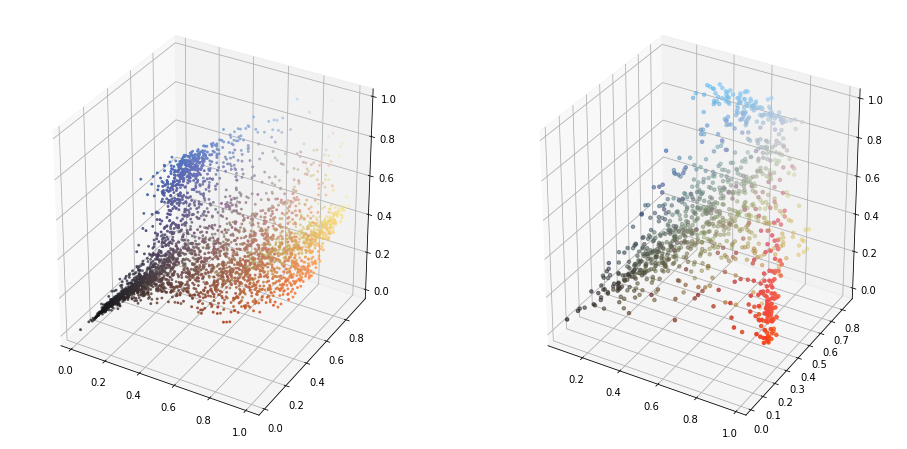

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sample_interval = 8 if device == torch.device("cpu") else 1
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection="3d")
display_cloud(ax, src_img)
ax = fig.add_subplot(1, 2, 2, projection="3d")
display_cloud(ax, tgt_img)

In [33]:
def train(source_image, target_image, num_steps=10, lr=1.0, blur=0.3):            
    loss_fn = SamplesLoss("sinkhorn", blur=blur)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"device={device}")
    sample_interval = 8 if device == torch.device("cpu") else 1
    source_x = torch.from_numpy(image2cloud(source_image, sample_interval)).type(torch.FloatTensor).to(device)
    target_x = torch.from_numpy(image2cloud(target_image, sample_interval)).type(torch.FloatTensor).to(device)
    source_x.requires_grad = True    

    optimizer = optim.SGD([source_x], lr=lr * len(source_x))

    for i in trange(num_steps):

        loss = loss_fn(source_x, target_x)

        optimizer.zero_grad()
        # or
        # if i > 0:
            # source_x.grad.zero_()

        loss.backward()

        optimizer.step()
        # or
        # source_x.data -= lr * len(source_x) * source_x.grad                
    
    h, w = source_image.shape[:2]
    h, w = h // sample_interval, w // sample_interval        
    result_image = source_x.detach().cpu().numpy().reshape(h, w, 3)
    return result_image

(-0.5, 255.5, 255.5, -0.5)

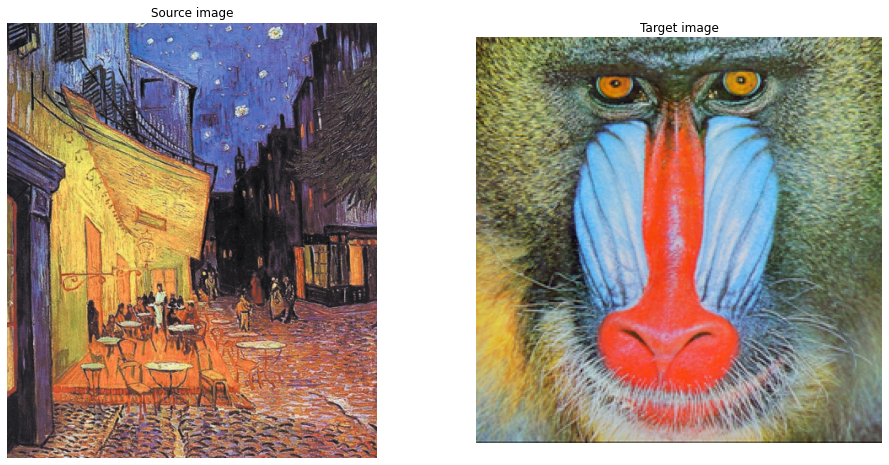

In [34]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.imshow(src_img)
ax.set_title("Source image")
ax.axis("off")
ax = plt.subplot(1, 2, 2)
ax.imshow(tgt_img)
ax.set_title("Target image")
ax.axis("off")

In [35]:
result_img = train(src_img, tgt_img, num_steps=10, lr=1.0, blur=0.3)

device=cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

(-0.5, 438.5, 515.5, -0.5)

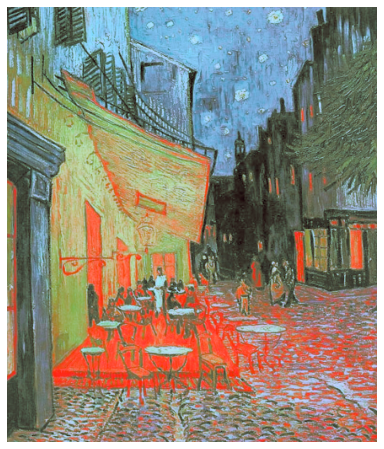

In [36]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.imshow(result_img)
ax.axis("off")